# Experiment Iterative Quantum Amplitude Estimatio Parallelization

In [1]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt

from multivariateGCI_mr import MultivariateGCI_mr
from multivariateGCI_sr import MultivariateGCI_sr

from qiskit import QuantumRegister, QuantumCircuit, Aer, execute, IBMQ, transpile, ClassicalRegister
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem, AmplitudeEstimation
#from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit.library import LinearAmplitudeFunction, QFT
from qiskit.circuit.library import LinearAmplitudeFunction

In [18]:
df = pd.read_csv("Data/sampled_counterparts.csv")
# df = df[((df['pd']>=0.1) & ((1000 < df['lgd dwt']*df['ead']) & (df['lgd dwt']*df['ead'] < 5000000)))]
asset_class = [38-2, 260-2]
df =  df.iloc[asset_class] #df.iloc[[38-2, 260-2, 7816-2]] 

F_matrix = pd.read_csv("Data/F_for_sampled_counterparts.csv")
sectors = [1] #[1, 2]
F_values = [[F_matrix.iloc[df.index.values[j]][i-1] for i in sectors] for j in range(len(df))]
# F_values = [[0.55], [0.65], [0.50]] # make F/rhos

## Parameter Setting

In [3]:
# set problem parameters
n_z = 2
z_max = 2

p_zeros = [el['pd'] for _, el in df.iterrows()]
rhos = [el['is']**2 for _, el in df.iterrows()]
lgd = [el['lgd dwt']*el['ead'] for _, el in df.iterrows()]

K = len(p_zeros)

alpha_var = 0.05

compute_depth = False
serialization = False

print(f'F: {F_values}\nRhos: {np.sqrt(rhos)}\nLgds: {lgd}\np_zeros: {p_zeros}')
df

F: [[0.1580707722], [0.2555327991]]
Rhos: [0.3 0.3]
Lgds: [18406.56224845756, 54807.94141703075]
p_zeros: [0.2565108504, 0.0715568886]


,cluster,pd,lgd dwt,ead,num ctp,sett,is,acca,cod type,cod stato,lgd pag
36,005118_618,0.256511,0.223071,82514.537908,83292,5,0.3,0.000083,0,0,0.187699
258,002116_18,0.071557,0.194311,282063.242107,888,2,0.3,0.019318,0,0,0.157672


In [4]:
# Encoding of the uncertainty model

u = MultivariateGCI_mr(n_z, z_max, p_zeros, rhos, F_values)

In [5]:
def mapping(decimal_number):
    b = ('{0:0%sb}' % K).format(decimal_number)
    #print(b)
    losses = [loss for i, loss in enumerate(lgd[::-1]) if b[i]=='1']
    #print(losses)
    total_loss = sum(losses)
    return total_loss

def find_breakpoint(x_eval):
    for el in range(0,2**K):
        if mapping(el) <= x_eval:
            if mapping(el+1) >= x_eval:
                return el
    return 0


In [6]:
def get_cdf_circuit(x_eval):
    
    # define linear objective function for expected loss
    breakpoints = list(range(0,2**K))
    slopes = [0]*len(breakpoints)
    offsets = [mapping(el) for el in breakpoints]
    f_min = 0
    f_max = sum(lgd)
    c_approx = 0.01


    objective_e_loss = LinearAmplitudeFunction(
        K,
        slope=slopes, 
        offset=offsets, 
        # max value that can be reached by the qubit register (will not always be reached)
        domain=(0, 2**K-1),  
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints
    )

    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, 'state')
    qr_obj = QuantumRegister(1, 'objective')
    ar = QuantumRegister(objective_e_loss.num_ancillas, "work")  # additional qubits

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, ar, name='A')

    # load the random variable
    state_preparation.append(u.to_gate(), qr_state)

    # linear objective function (does aggregation and comparison)
  
    state_preparation.append(objective_e_loss.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
    
    return state_preparation, objective_e_loss

In [7]:
example = 0
state_preparation, objective_e_loss = get_cdf_circuit(example)

In [8]:
objective_e_loss.decompose().draw()

┌────┐
q5_0: ┤0   ├
      │    │
q5_1: ┤1   ├
      │    │
  q6: ┤2 F ├
      │    │
a0_0: ┤3   ├
      │    │
a0_1: ┤4   ├
      └────┘

In [9]:
# set target precision and confidence level
epsilon = 0.01/6
alpha = 0.05/6

simulated = True
optimization_level = 1
n_shots = 10000

qi_ideal = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=n_shots, 
                           optimization_level=optimization_level, seed_transpiler=42)


#coupling_map = backend.configuration().coupling_map
#basis_gates = noise_model.basis_gates

#qi_noise = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=n_shots, 
#                        optimization_level=optimization_level, seed_transpiler=42,
#                        noise_model=noise_model, basis_gates=basis_gates, coupling_map=coupling_map)

problem = EstimationProblem(state_preparation=state_preparation,
                            objective_qubits=[u.num_qubits],
                            post_processing=objective_e_loss.post_processing)

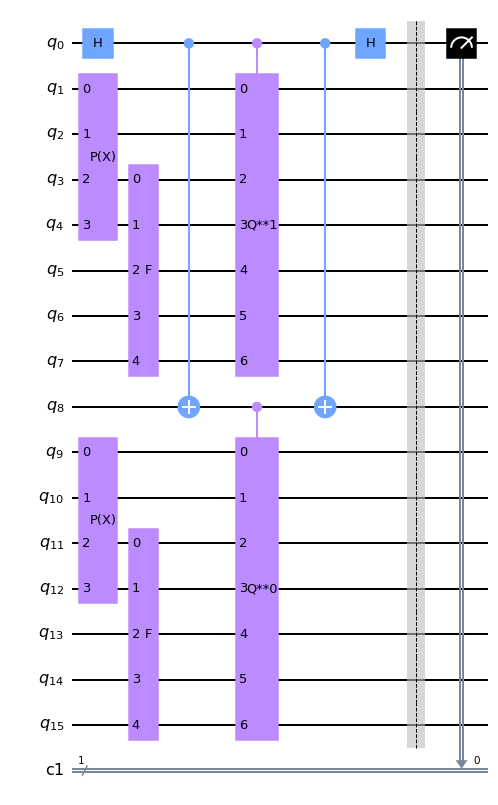

In [12]:
from parallel_iae import ParallelIterativeAmplitudeEstimation

piae = ParallelIterativeAmplitudeEstimation(alpha=0.05, epsilon_target=0.002, l=2, quantum_instance=qi_ideal)
circuit = piae.construct_circuit(k=1, estimation_problem=problem, measurement=True)
circuit.draw("mpl")

### Results

In [19]:
results = pd.DataFrame()

In [20]:
from datetime import datetime
import pytz

n_simulation = 5

for i in range(n_simulation):

    amplitude_estimation_instance = piae
    backend_name = 'qasm_simulator'
    execution_backend = 'Noiseless Simulator'
    Quantum_Volume = ''

    now = datetime.now(tz=pytz.timezone("Europe/Rome"))
    result = amplitude_estimation_instance.estimate(problem)
    now_1 = datetime.now(tz=pytz.timezone("Europe/Rome"))


    results = results.append({  'Device':backend_name,
                                'Quantum Volume': Quantum_Volume,
                                'qubits':problem.state_preparation.num_qubits,
                                'Execution_backend':execution_backend,
                                'Asset Class':asset_class,
                                'Risk Factor':sectors,
                                'Expected Total Loss':result.estimation_processed,
                                },ignore_index=True)

1
39
1
39
1
43
1
39
1
29


In [21]:
results.to_excel("Data/parallelization_results.xlsx")

In [35]:
# mode = 'parallel'
# k = 20

# df = pd.DataFrame()
# for i in range(k):

#     state_preparation3, _ = get_parallelized_iqae_circuit(i, u, objective_e_loss)
    
#     qi_ideal = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=n_shots, 
#                            optimization_level=optimization_level, seed_transpiler=42)
#     problem = EstimationProblem(state_preparation=state_preparation,
#                             objective_qubits=[u.num_qubits],
#                             post_processing=objective_e_loss.post_processing)
    
#     counts = qi_ideal.execute(state_preparation3).get_counts(state_preparation3)

#     one_counts = 0
#     for state, count in counts.items():
#         if problem.is_good_state(state):
#             one_counts += count
#     #iqae_ideal_result = one_counts / sum(counts.values())
#     df = df.append({'iterations':i, 'P_1':one_counts}, ignore_index=True)

<AxesSubplot:xlabel='iterations'>

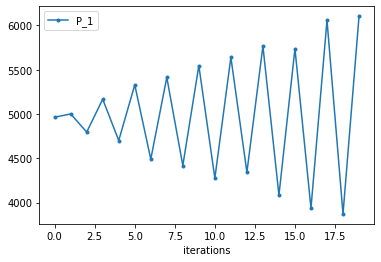

In [37]:
# df.set_index('iterations').plot(style='.-')

In [28]:
mode = 'sequential'
sequential_k = 20

df_s = pd.DataFrame()
for i in range(16):
    
    qi_ideal = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=n_shots, 
                           optimization_level=optimization_level, seed_transpiler=42)
    problem = EstimationProblem(state_preparation=state_preparation,
                            objective_qubits=[u.num_qubits],
                            post_processing=objective_e_loss.post_processing)
    
    iqae = IterativeAmplitudeEstimation(epsilon_target=0.01, alpha=0.1, quantum_instance=qi_ideal)
    iqae_circuit = iqae.construct_circuit(problem, k=i, measurement=True)

    counts = qi_ideal.execute(iqae_circuit).get_counts(iqae_circuit)

    one_counts = 0
    for state, count in counts.items():
        if problem.is_good_state(state):
            one_counts += count
    df_s = df_s.append({'iterations':i, 'P_1':one_counts}, ignore_index=True)

<AxesSubplot:xlabel='iterations'>

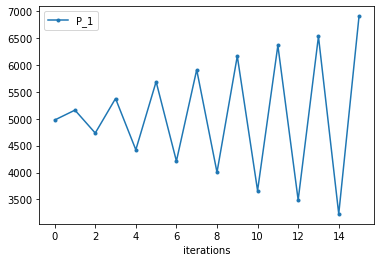

In [29]:
df_s.set_index('iterations').plot(style='.-')

In [39]:
# df_tot = df.merge(df_s, left_index=True, right_index=True,suffixes=('_parallel','_sequential'))

<AxesSubplot:>

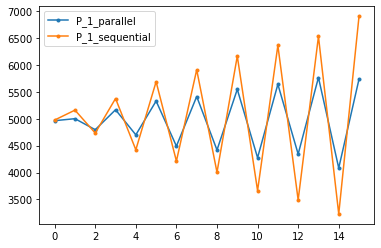

In [40]:
# df_tot = df_tot[['P_1_parallel', 'P_1_sequential']]
# df_tot.plot(style='.-')

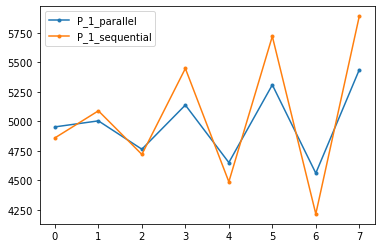

In [204]:
# df_par = df_par[['P_1_parallel', 'P_1_sequential']].plot(style='.-')

In [223]:
# df_tot['diff'] = df_tot.eval(" P_1_parallel - P_1_sequential ")

In [224]:
# df_tot

,P_1_parallel,P_1_sequential,diff
0,4876.0,5011.0,-135.0
1,5116.0,5126.0,-10.0
2,4798.0,4652.0,146.0
3,5075.0,5404.0,-329.0
4,4770.0,4490.0,280.0
5,5229.0,5623.0,-394.0
6,4511.0,4208.0,303.0
7,5398.0,5901.0,-503.0
8,4470.0,3968.0,502.0
9,5574.0,6182.0,-608.0
